## **Proposed Correction to PCA Outlier Detection Methodology in PyOD**

This notebook reviews the existing methodology for PCA Outlier Detection applied by the PyOD python package and recommends a correction to the outlier score calculation. The PR for the logic I describe can be referenced [here](https://github.com/yzhao062/pyod/pull/340). The PyOD version at the time this notebook was written was 0.9.3.


#### **References:**
1. **PyOD Package:** https://github.com/yzhao062/pyod/blob/master/pyod/models/pca.py
2. **Theory (pages 75-78):** Aggarwal, C. C. (2016). Linear Models for Outlier Detection. Outlier Analysis, 65–110. doi:10.1007/978-3-319-47578-3_3

In [1]:
# libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from pyod.models.pca import PCA as PCA # ! pip install pyod==0.9.3
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

random.seed(1)

#### **Background**

Principal component analysis (PCA) for outlier detection leverages the PCA dimensionality reduction technique, where the key point to note is that eigenvectors with larger eigenvalues represent the hyperplane where the majority of a dataset's variance lies. The premise of this outlier detection methodology is that data points with larger Euclidean distances to the mean of the data points in that principal component are anomalous. Aggarwal et al., 2016 demonstrates this concept in their Figure 3.4 on page 77, where point X on the top right is considered an outlier as it has the furthest distance to the first eigenvector (passing through the mean of the data).

<center><img src="Aggarwal_Fig3.4.png" width="500px"></center>

The outlier scores calculation boils down to:

$$Score = \sum\limits _{j=1}^{d} \frac{|(\bar X - \bar \mu)\bar e_j|^{2}}{\lambda_{j}}$$

where the anomaly score of pca-transformed data point $\bar X$ is computed as the sum of squared distances to the centroid of the transformed data, $\bar \mu$ (which, with standardized data = 0), normalized by the eigenvectors' eigenvalue, $\lambda_j$. The intuition behind scaling by the eigenvalue is that larger deviations along a smaller eigenvalue should be given greater weight.

The computational steps I have taken in the code below to achieve these scores are outlined on page 78 of Aggarwal et al.:
1. Compute PCA-transformed data, D', which is done below using sklearn's PCA class.
2. Normalize each column of D' by the eigenvalue resembling the variance of the data in that direction.
3. Compute the summed, squared Euclidean distance of each record in D' from its centroid (centroid equals 0 for standardized data and this can be ignored) as the outlier score.

#### **Generate Sample Data**

Two-dimensional sample data is generated with a known anomaly at point [1,100] in Figure 1, resembling the example provided by Aggarwal et al., 2016 above.

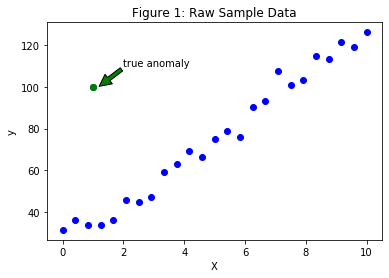

In [2]:
# function to generate random points on a line
def line(x, m, b):
    return m*x + b

X = np.linspace(0, 10, 25)
y = [line(x, 10, 5) + abs(random.gauss(20,5)) for x in X]

# insert anomaly
X = np.append(X, 1)
y = np.append(y, 100)

plt.scatter(X, y, c='b')
plt.scatter(1, 100, c='green') # true anomaly

# plot raw data
plt.title('Figure 1: Raw Sample Data')
plt.annotate("true anomaly",xy=(1.2,100.2),xytext=(2,110),arrowprops=dict(facecolor="green"))
plt.xlabel('X')
plt.ylabel('y')
plt.show()

# format X and y into a df
df = pd.DataFrame({'X':X,'y':y})
# scale df using StandardScaler (used in the same manner as documented in PyOD's utils files)
scaler = StandardScaler().fit(df)
df = scaler.transform(df)

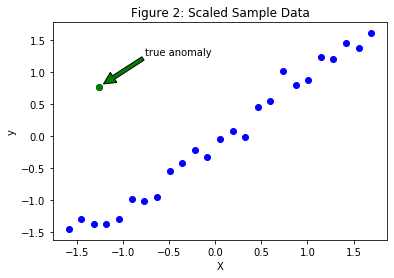

In [3]:
# plot scaled data
plt.scatter(df[:,0], df[:,1], c='blue')
X_anomaly = df[len(df)-1][0]
y_anomaly = df[len(df)-1][1]
plt.scatter(X_anomaly, y_anomaly, c='green') # last point is true anomaly
plt.title('Figure 2: Scaled Sample Data')
plt.annotate("true anomaly",xy=(X_anomaly+0.05, y_anomaly+0.05),xytext=(X_anomaly + 0.5, y_anomaly + 0.5),arrowprops=dict(facecolor="green"))
plt.xlabel('X')
plt.ylabel('y')
plt.show()

#### **PCA For Outlier Detection, Using PyOD Package**

In [4]:
# format back into a dataframe
df = pd.DataFrame(df)
df.columns = ['X','y']

# define PCA outlier detection classifier
clf = PCA(n_components=None, contamination=0.2, random_state=123) # contamination=0.2 hard-codes 20% of data points to be outliers
clf.fit(df)

# add metrics to dataframe
df['pyod_pca_outlier_scores'] = clf.decision_scores_ # anomaly detection scores, higher = anomalous
df['pyod_pca_outlier_label'] = clf.labels_ # labeled 1 as anomaly, 0 otherwise
df['pyod_pca_outlier_rank'] = df.pyod_pca_outlier_scores.rank(ascending=False).astype('int') # rank from most (1) to least (len(df)) anomalous

# view true and PyOD-determined anomalies in a table
def colour_anomalies(df):
    df_colour = df.copy()
    #set by condition
    pyod_anomaly = df_colour['pyod_pca_outlier_label'] == 1
    true_anomaly = df_colour.index==np.where((df_colour.X==X_anomaly) & (df_colour.y==y_anomaly))[0][0]
    # true_anomaly = df_colour['pyod_pca_decision_scores'] == 1
    df_colour.loc[pyod_anomaly, :] = 'background-color: red'
    df_colour.loc[~pyod_anomaly,:] = 'background-color: ""'
    df_colour.loc[true_anomaly, :] = 'background-color: green'
    return df_colour

# view dataframe: red highlights the top 5 anomalies according to PyOD methodology, green highlights the "true" anomaly I've inserted
df.style.apply(colour_anomalies, axis=None)

,X,y,pyod_pca_outlier_scores,pyod_pca_outlier_label,pyod_pca_outlier_rank
0,-1.591491,-1.457458,53.954391,1,2
1,-1.454656,-1.296342,49.404844,0,7
2,-1.317822,-1.385401,50.265046,1,4
3,-1.180987,-1.385004,49.415215,0,6
4,-1.044153,-1.303084,46.941365,0,8
5,-0.907318,-0.986093,39.381084,0,12
6,-0.770484,-1.021748,39.854581,0,11
7,-0.633649,-0.953937,38.249523,0,13
8,-0.496815,-0.553904,29.517123,0,17
9,-0.359980,-0.429593,27.376628,0,21


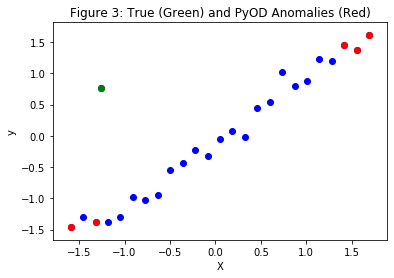

In [5]:
# Plot PyOD anomalies alongsize entire dataset

X_pyod_anomaly = df.loc[df.iloc[:,3]==1]['X']
y_pyod_anomaly = df.loc[df.iloc[:,3]==1]['y']

plt.scatter(df.X, df.y, c='blue') # non-outliers
plt.scatter(X_anomaly, y_anomaly, c='green') # true outlier
plt.scatter(X_pyod_anomaly, y_pyod_anomaly, c='red') # PyOD-defined outlier

plt.title('Figure 3: True (Green) and PyOD Anomalies (Red)')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

As shown in Figure 3 above, PyOD's PCA anomaly detection score is actually labelling the true anomaly as the _least_ anomalous point in the dataset.

**Why?**

According to this source code ([lines 268-270 here](https://github.com/yzhao062/pyod/blob/master/pyod/models/pca.py)), the suspected "true anomaly" is actually given the _least_ anomalous score because the package is computing the euclidean distance of each coordinate to the _tip_ of the eigenvectors, normalized by their explained variance ratio. In contrast, indices 0,2,22,23, and 24 are given the highest anomaly scores even though they are along the plane where the majority of the variance lies and intuitively should not be categorized as more anomalous than index 25. This is because these points have the furthest Euclidean distance from the _tips_ of both eigenvectors.

When I break down the formula manually below, the decision_scores_raw_ formula returns the exact same scores returned from the PyOD classifier. This is a sanity check that the methodology in this package is understood.

In [6]:
selected_components_ = clf.selected_components_ # matrix of eigenvectors representing the 2-D direction of variance in the data
selected_w_components_ = clf.w_components_[-2:] # explained variance of each of the principal components, summing 1

# manually deconstruct PyOD outlier score formula
decision_scores_raw_ = np.sum(
            distance.cdist(df[['X','y']], selected_components_) / selected_w_components_,
            axis=1).ravel()

# confirming the calculation is understood
df['pyod_pca_outlier_scores_manual'] = decision_scores_raw_ # same df displayed above, with manually calculated outlier scores in final column
df.pyod_pca_outlier_scores = df.pyod_pca_outlier_scores

df.style.apply(colour_anomalies, axis=None)

,X,y,pyod_pca_outlier_scores,pyod_pca_outlier_label,pyod_pca_outlier_rank,pyod_pca_outlier_scores_manual
0,-1.591491,-1.457458,53.954391,1,2,53.954391
1,-1.454656,-1.296342,49.404844,0,7,49.404844
2,-1.317822,-1.385401,50.265046,1,4,50.265046
3,-1.180987,-1.385004,49.415215,0,6,49.415215
4,-1.044153,-1.303084,46.941365,0,8,46.941365
5,-0.907318,-0.986093,39.381084,0,12,39.381084
6,-0.770484,-1.021748,39.854581,0,11,39.854581
7,-0.633649,-0.953937,38.249523,0,13,38.249523
8,-0.496815,-0.553904,29.517123,0,17,29.517123
9,-0.359980,-0.429593,27.376628,0,21,27.376628


#### **Corrected PCA Outlier Detection Score**

A revised outlier score that satisfies the rationale described in the theory outlined by Arrgewal et al. is computed below using sklearn's PCA class. As a reminder, the following steps are taken:

1. Compute PCA-transformed data, D', which is done below using sklearn's PCA class.
2. Normalize each column of D' by the eigenvalue resembling the variance of the data in that direction.
3. Compute the summed, squared Euclidean distance of each record in D' from its centroid (centroid equals 0 for standardized data and this can be ignored) as the outlier score.

In [7]:
from sklearn.decomposition import PCA as sklearn_PCA
data = df[['X','y']] # scaled data
pca = sklearn_PCA(n_components=None)
revised_decision_scores_ = np.sum((((pca.fit_transform(data) - pca.fit_transform(data).mean(axis=0))/ pca.explained_variance_ratio_))** 2, axis=1).ravel()

revised_decision_scores_

# where:
# data is the scaled data with mean 0
# pca.fit_transform(X) is the pca-transformed data, D' in above description
# pca.fit_transform(X).mean(axis=0) is the mean of the principal components; when data is scaled, mean = 0 and this becomes redundant, this can be removed
# pca.explained_variance_: proportion of variance explained by each principal component; used for weighting anomaly scores

array([9.32264902e+00, 1.00378998e+01, 5.08718625e+00, 1.33813490e+01,
       1.87536831e+01, 3.42576174e+00, 1.65735859e+01, 2.54468062e+01,
       1.37121034e+00, 1.47926480e+00, 1.16528704e-01, 1.39402607e+01,
       2.15867139e+00, 2.82929445e+00, 2.78649578e+01, 5.05661505e-01,
       1.35683682e+00, 2.02126118e+01, 2.84574584e+00, 6.10388706e+00,
       4.93471774e+00, 4.93160185e+00, 4.76782790e+00, 1.20185272e+01,
       7.62617051e+00, 9.63687133e+02])

The following is a simple classifer that will take in raw unscaled data as an argument and return pca decision scores according to the revised methodology above:

In [8]:
from sklearn.decomposition import PCA as sklearn_PCA
from pyod.utils.utility import check_parameter
from pyod.utils.utility import standardizer

class PCA():
    def __init__(self, n_components=None, copy=True, whiten=False, svd_solver='auto',
                 tol=0.0, iterated_power='auto', random_state=None, standardization=True):
        self.n_components = n_components
        self.copy = copy
        self.whiten = whiten
        self.svd_solver = svd_solver
        self.tol = tol
        self.iterated_power = iterated_power
        self.random_state = random_state
        self.standardization = standardization
        
    def fit_transform(self, X, y=None):

        # standardize data with the pyod standardizer function
        if self.standardization:
            X, self.scaler_ = standardizer(X, keep_scalar=True)

        # define sklearn PCA class
        self.detector_ = sklearn_PCA(n_components=self.n_components,
                                     copy=self.copy,
                                     whiten=self.whiten,
                                     svd_solver=self.svd_solver,
                                     tol=self.tol,
                                     iterated_power=self.iterated_power,
                                     random_state=self.random_state)
        
        self.decision_scores_ = np.sum((((self.detector_.fit_transform(X) - pca.fit_transform(data).mean(axis=0))/ self.detector_.explained_variance_ratio_))** 2, axis=1).ravel()

        return self

In [9]:
# apply above PCA Outlier Detection classifier on raw X and y coordinates, unscaled
data = pd.DataFrame({'X':X,'y':y}) # unscaled
pca_od = PCA()
pca_od.fit_transform(data)
data['pca_outlier_scores'] = pca_od.decision_scores_
data.sort_values(by='pca_outlier_scores', ascending=False)

,X,y,pca_outlier_scores
25,1.000000,100.000000,963.687133
14,5.833333,75.804188,27.864958
7,2.916667,46.982519,25.446806
17,7.083333,107.778894,20.212612
4,1.666667,36.205801,18.753683
6,2.500000,44.889484,16.573586
11,4.583333,66.263479,13.940261
3,1.250000,33.677282,13.381349
23,9.583333,119.005612,12.018527
1,0.416667,36.413895,10.037900


As expected, coordinate [1,100] (index 25) is now correctly identified as the **most** anomalous data point in the population.